# Downwelling Irradiance (Ed) Calculations

This notebook demonstrates the calculation of **downwelling irradiance Ed(0+)** at the sea surface, which is essential for computing remote-sensing reflectance:

$$R_{rs} = \frac{L_w}{E_d(0^+)}$$

Key topics covered:

1. **Solar Spectrum** - High-resolution extraterrestrial solar irradiance (F0)
2. **Atmospheric Transmittance** - Direct and diffuse components
3. **Ed Calculation** - Combining all factors to compute surface irradiance
4. **PACE Hyperspectral Support** - 1 nm resolution for next-generation sensors

The module uses the **TSIS-1 HSRS** (Hybrid Solar Reference Spectrum) from Coddington et al. (2021), which is the current NASA standard for ocean color processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from correct_atmosphere.downwelling import (
    get_solar_spectrum,
    extraterrestrial_solar_irradiance,
    solar_zenith_factor,
    downwelling_irradiance,
    downwelling_irradiance_direct,
    downwelling_irradiance_diffuse,
    downwelling_irradiance_spectral,
    get_pace_wavelengths,
    convert_irradiance_units,
    PACE_OCI_WAVELENGTHS,
)
from correct_atmosphere import constants

---
## 1. Solar Spectrum (F0)

The extraterrestrial solar irradiance **F0** is the foundation for all Ed calculations. We use the **TSIS-1 Hybrid Solar Reference Spectrum (HSRS)** which provides:

- 1 nm resolution from 300-1000 nm
- Based on TSIS-1 SIM measurements (2018-2020)
- Current NASA standard for ocean color processing

In [2]:
# Load the full solar spectrum
spectrum = get_solar_spectrum()

print(f"Solar Spectrum Source: {spectrum.source}")
print(f"Resolution: {spectrum.resolution} nm")
print(f"Wavelength range: {spectrum.wavelengths[0]:.0f} - {spectrum.wavelengths[-1]:.0f} nm")
print(f"Number of wavelengths: {len(spectrum.wavelengths)}")

Solar Spectrum Source: TSIS-1 HSRS v2 (Coddington et al. 2021)
Resolution: 1.0 nm
Wavelength range: 202 - 2730 nm
Number of wavelengths: 25281


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/3638034375.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Solar Irradiance F0 (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)


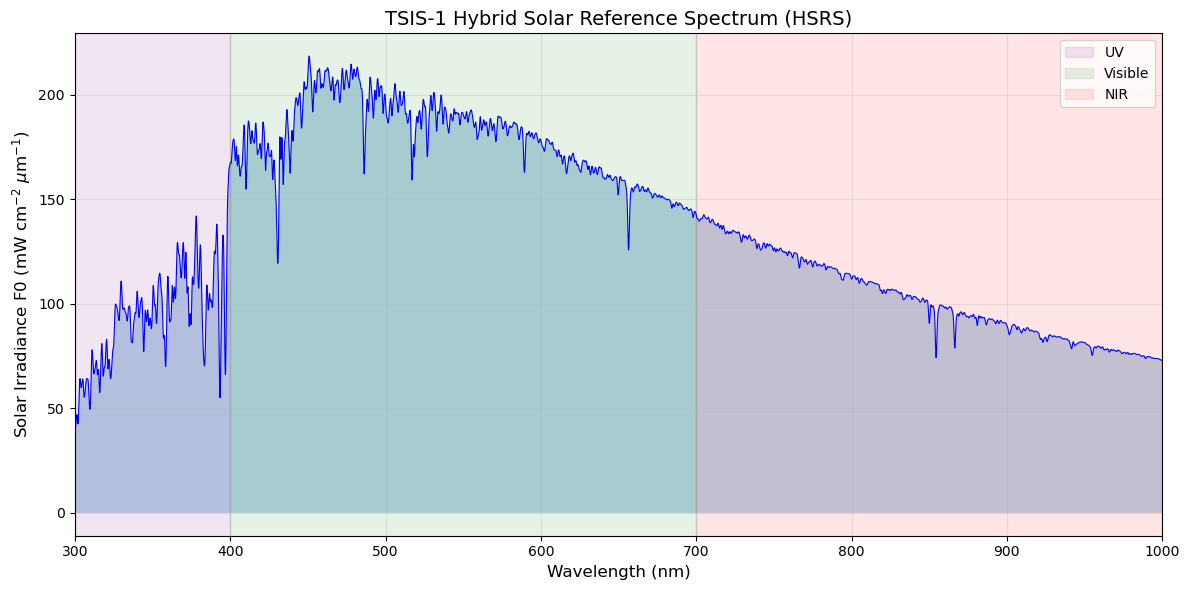

In [3]:
# Plot the full solar spectrum
plt.figure(figsize=(12, 6))
plt.plot(spectrum.wavelengths, spectrum.f0, 'b-', linewidth=0.8)
plt.fill_between(spectrum.wavelengths, spectrum.f0, alpha=0.3)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Solar Irradiance F0 (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
plt.title('TSIS-1 Hybrid Solar Reference Spectrum (HSRS)', fontsize=14)
plt.xlim(300, 1000)
plt.grid(True, alpha=0.3)

# Mark key spectral regions
plt.axvspan(300, 400, alpha=0.1, color='purple', label='UV')
plt.axvspan(400, 700, alpha=0.1, color='green', label='Visible')
plt.axvspan(700, 1000, alpha=0.1, color='red', label='NIR')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### F0 at Ocean Color Wavelengths

Let's examine F0 values at the standard ocean color bands used by SeaWiFS, MODIS, and VIIRS.

In [4]:
# Standard ocean color wavelengths
ocean_color_bands = np.array([412, 443, 490, 510, 555, 670, 765, 865])

# Get F0 at each wavelength
f0_bands = spectrum.interpolate(ocean_color_bands)

print("Extraterrestrial Solar Irradiance F0 at Ocean Color Bands:")
print("=" * 55)
print(f"{'Wavelength (nm)':<18} {'F0 (mW/cm2/um)':<18} {'F0 (W/m2/nm)'}")
print("-" * 55)
for wl, f0 in zip(ocean_color_bands, f0_bands):
    f0_si = f0 * 0.1  # Convert to W/m2/nm
    print(f"{wl:<18} {f0:<18.2f} {f0_si:.2f}")

Extraterrestrial Solar Irradiance F0 at Ocean Color Bands:
Wavelength (nm)    F0 (mW/cm2/um)     F0 (W/m2/nm)
-------------------------------------------------------
412                186.88             18.69
443                197.17             19.72
490                208.16             20.82
510                195.17             19.52
555                192.59             19.26
670                153.38             15.34
765                123.52             12.35
865                95.96              9.60


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/2023580877.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('F0 (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)


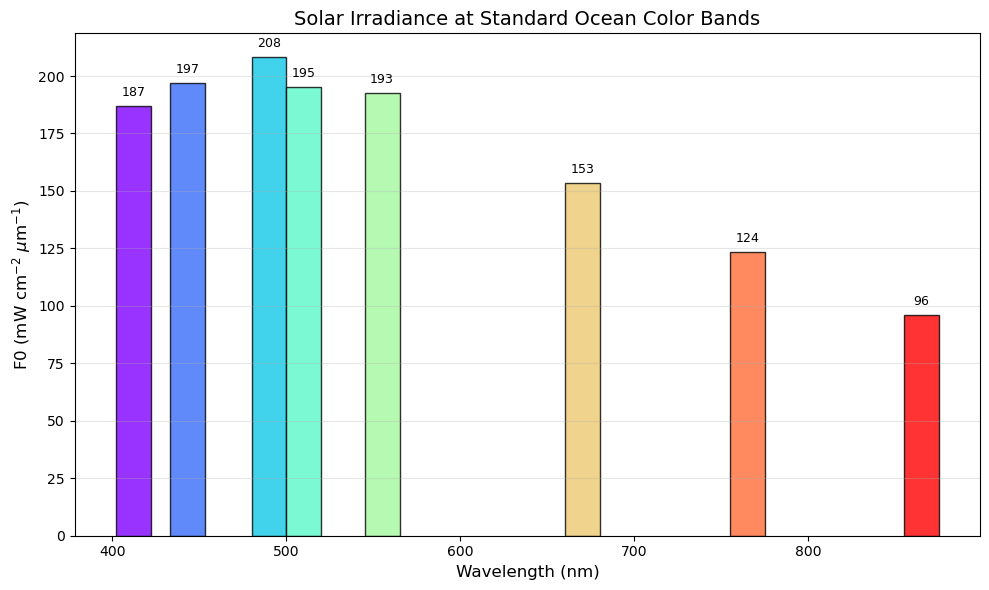

In [5]:
# Bar plot of F0 at ocean color bands
colors = plt.cm.rainbow(np.linspace(0, 1, len(ocean_color_bands)))

plt.figure(figsize=(10, 6))
bars = plt.bar(ocean_color_bands, f0_bands, width=20, color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('F0 (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
plt.title('Solar Irradiance at Standard Ocean Color Bands', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, f0 in zip(bars, f0_bands):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             f'{f0:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Earth-Sun Distance Correction

The solar irradiance at Earth varies throughout the year due to Earth's elliptical orbit:

$$F_0(actual) = F_0(mean) \times \left(\frac{R_0}{R}\right)^2$$

where R is the actual Earth-Sun distance and R0 is the mean distance (1 AU).

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/3623293454.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel(f'F0 at {wavelength:.0f} nm (mW cm$^{{-2}}$ $\mu$m$^{{-1}}$)', fontsize=12)


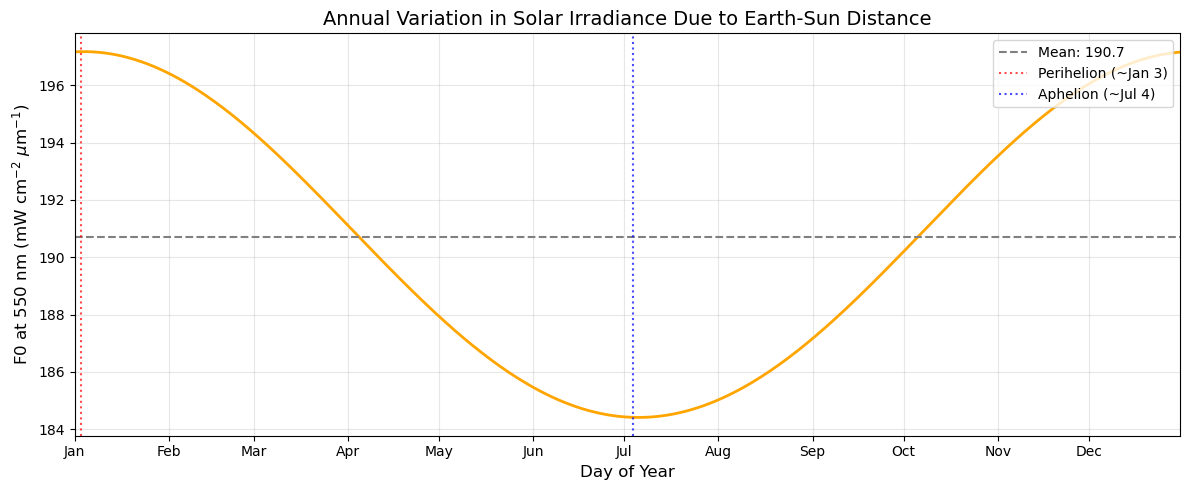


Variation: 6.7%


In [6]:
# F0 variation over the year at 550 nm
days = np.arange(1, 366)
wavelength = 550.0

f0_yearly = np.array([extraterrestrial_solar_irradiance(wavelength, day_of_year=day) 
                      for day in days])

plt.figure(figsize=(12, 5))
plt.plot(days, f0_yearly, 'orange', linewidth=2)
plt.axhline(f0_yearly.mean(), color='gray', linestyle='--', label=f'Mean: {f0_yearly.mean():.1f}')

# Mark perihelion and aphelion
plt.axvline(3, color='red', linestyle=':', alpha=0.7, label='Perihelion (~Jan 3)')
plt.axvline(185, color='blue', linestyle=':', alpha=0.7, label='Aphelion (~Jul 4)')

plt.xlabel('Day of Year', fontsize=12)
plt.ylabel(f'F0 at {wavelength:.0f} nm (mW cm$^{{-2}}$ $\mu$m$^{{-1}}$)', fontsize=12)
plt.title('Annual Variation in Solar Irradiance Due to Earth-Sun Distance', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(1, 365)

# Add month labels
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_days, month_names)

plt.tight_layout()
plt.show()

print(f"\nVariation: {(f0_yearly.max() - f0_yearly.min()) / f0_yearly.mean() * 100:.1f}%")

---
## 2. Downwelling Irradiance Components

The total downwelling irradiance at the sea surface has two components:

$$E_d(0^+) = E_d^{dir} + E_d^{dif}$$

- **Direct (beam)**: Sunlight that passes directly through the atmosphere
- **Diffuse (sky)**: Sunlight scattered by the atmosphere that still reaches the surface

### Solar Zenith Angle Effect

Ed decreases with increasing solar zenith angle due to:
1. The geometric factor cos(θs)
2. Longer atmospheric path length

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/1818264362.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel(f'Ed at {wavelength:.0f} nm (mW cm$^{{-2}}$ $\mu$m$^{{-1}}$)', fontsize=12)


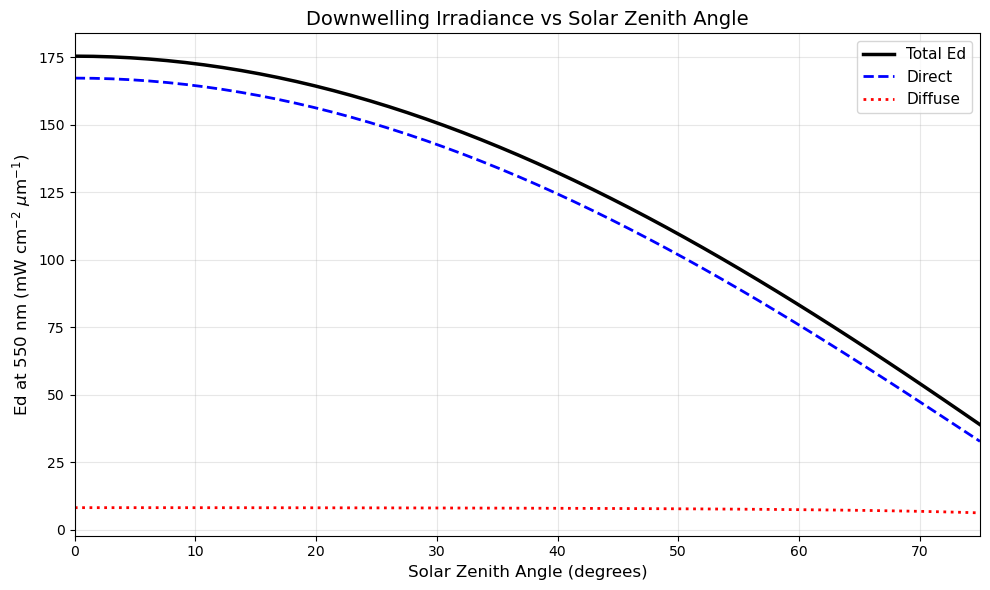

In [7]:
# Ed vs solar zenith angle
wavelength = 550.0  # nm
solar_zeniths = np.linspace(0, 75, 50)

ed_total = np.array([downwelling_irradiance(wavelength, sza) for sza in solar_zeniths])
ed_direct = np.array([downwelling_irradiance_direct(wavelength, sza) for sza in solar_zeniths])
ed_diffuse = np.array([downwelling_irradiance_diffuse(wavelength, sza) for sza in solar_zeniths])

plt.figure(figsize=(10, 6))
plt.plot(solar_zeniths, ed_total, 'k-', linewidth=2.5, label='Total Ed')
plt.plot(solar_zeniths, ed_direct, 'b--', linewidth=2, label='Direct')
plt.plot(solar_zeniths, ed_diffuse, 'r:', linewidth=2, label='Diffuse')

plt.xlabel('Solar Zenith Angle (degrees)', fontsize=12)
plt.ylabel(f'Ed at {wavelength:.0f} nm (mW cm$^{{-2}}$ $\mu$m$^{{-1}}$)', fontsize=12)
plt.title('Downwelling Irradiance vs Solar Zenith Angle', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 75)

plt.tight_layout()
plt.show()

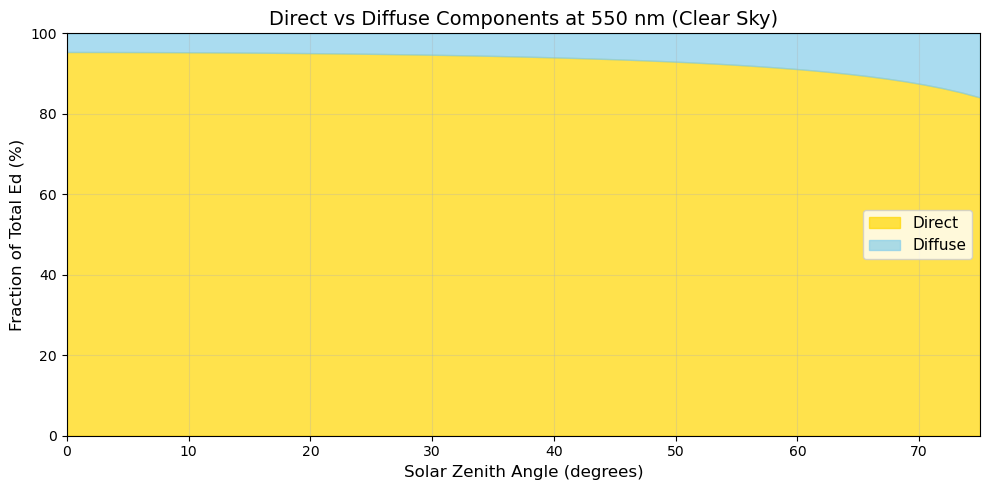

In [8]:
# Fraction of diffuse vs direct
diffuse_fraction = ed_diffuse / ed_total * 100

plt.figure(figsize=(10, 5))
plt.fill_between(solar_zeniths, 0, 100-diffuse_fraction, alpha=0.7, color='gold', label='Direct')
plt.fill_between(solar_zeniths, 100-diffuse_fraction, 100, alpha=0.7, color='skyblue', label='Diffuse')

plt.xlabel('Solar Zenith Angle (degrees)', fontsize=12)
plt.ylabel('Fraction of Total Ed (%)', fontsize=12)
plt.title(f'Direct vs Diffuse Components at {wavelength:.0f} nm (Clear Sky)', fontsize=14)
plt.legend(loc='center right', fontsize=11)
plt.xlim(0, 75)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Spectral Dependence

Ed varies with wavelength due to:
1. The shape of the solar spectrum (F0)
2. Rayleigh scattering (stronger at shorter wavelengths)
3. Gas absorption (O3 in the Chappuis band, NO2 in blue)

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/964706365.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(wavelengths, ed, linewidth=2, label=f'SZA = {sza}$^\circ$')
/tmp/ipykernel_65207/964706365.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Ed (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)


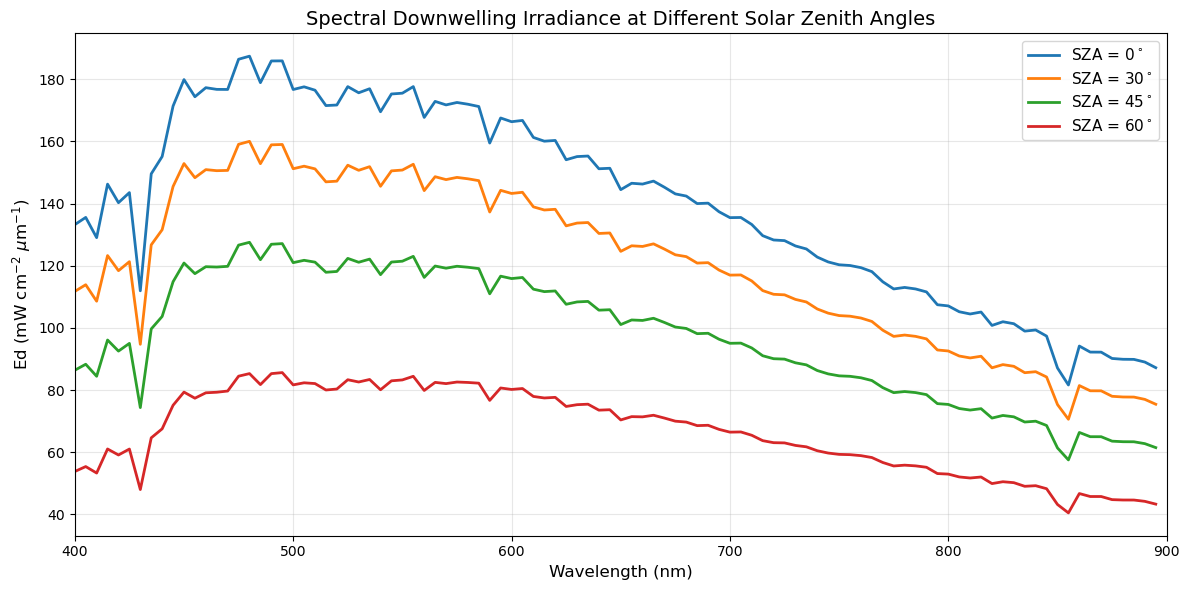

In [9]:
# Spectral Ed at different solar zenith angles
wavelengths = np.arange(400, 900, 5)
szas = [0, 30, 45, 60]

plt.figure(figsize=(12, 6))

for sza in szas:
    ed = downwelling_irradiance(wavelengths, sza)
    plt.plot(wavelengths, ed, linewidth=2, label=f'SZA = {sza}$^\circ$')

plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Ed (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
plt.title('Spectral Downwelling Irradiance at Different Solar Zenith Angles', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(400, 900)

plt.tight_layout()
plt.show()

### Aerosol Effects

Aerosols reduce Ed by scattering and absorbing sunlight. The effect depends on:
- Aerosol optical thickness (AOT)
- Angstrom exponent (wavelength dependence)

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_65207/2248229310.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Ed (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
/tmp/ipykernel_65207/2248229310.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f'Effect of Aerosol Loading on Ed (SZA = {solar_zenith}$^\circ$)', fontsize=14)


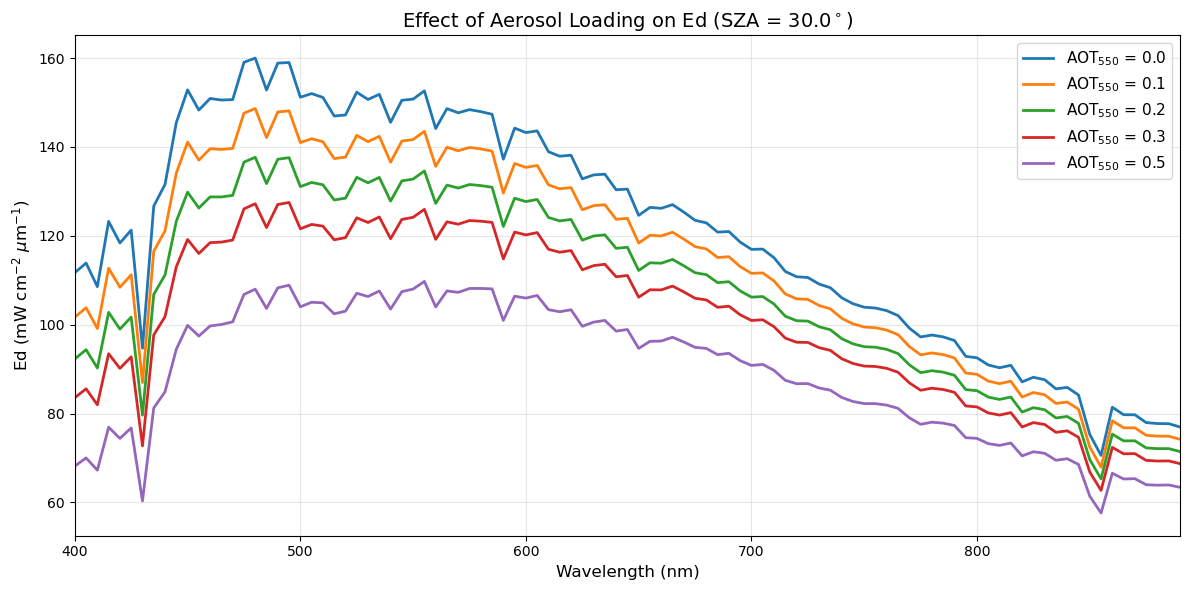

In [10]:
# Effect of aerosol optical thickness
aot_values = [0.0, 0.1, 0.2, 0.3, 0.5]
solar_zenith = 30.0

plt.figure(figsize=(12, 6))

for aot in aot_values:
    result = downwelling_irradiance_spectral(
        solar_zenith,
        wavelength_range=(400, 890),
        resolution=5.0,
        aerosol_tau_550=aot
    )
    plt.plot(result['wavelengths'], result['ed'], linewidth=2, 
             label=f'AOT$_{{550}}$ = {aot}')

plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Ed (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
plt.title(f'Effect of Aerosol Loading on Ed (SZA = {solar_zenith}$^\circ$)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(400, 890)

plt.tight_layout()
plt.show()

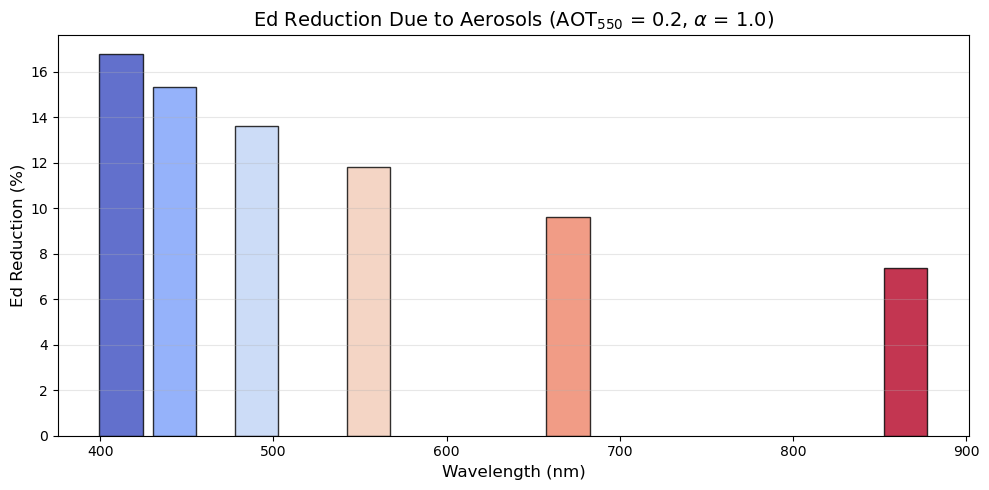


Ed Reduction at Each Wavelength:
  412 nm: 16.8%
  443 nm: 15.3%
  490 nm: 13.6%
  555 nm: 11.8%
  670 nm: 9.6%
  865 nm: 7.4%


In [11]:
# Ed reduction due to aerosols at different wavelengths
wavelengths = np.array([412, 443, 490, 555, 670, 865])
aot_550 = 0.2
angstrom = 1.0  # Typical maritime aerosol

# Calculate AOT at each wavelength
aot_spectral = aot_550 * (550.0 / wavelengths) ** angstrom

ed_clean = downwelling_irradiance(wavelengths, solar_zenith, aerosol_tau=0.0)
ed_aerosol = downwelling_irradiance(wavelengths, solar_zenith, aerosol_tau=aot_spectral)

reduction = (1 - ed_aerosol / ed_clean) * 100

plt.figure(figsize=(10, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(wavelengths)))
plt.bar(wavelengths, reduction, width=25, color=colors, edgecolor='black', alpha=0.8)

plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Ed Reduction (%)', fontsize=12)
plt.title(f'Ed Reduction Due to Aerosols (AOT$_{{550}}$ = {aot_550}, $\\alpha$ = {angstrom})', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nEd Reduction at Each Wavelength:")
for wl, red in zip(wavelengths, reduction):
    print(f"  {wl} nm: {red:.1f}%")

---
## 3. PACE Hyperspectral Support

The **PACE OCI** (Ocean Color Instrument) provides hyperspectral coverage:
- 340-890 nm at 5 nm resolution (111 bands)
- 7 SWIR bands for atmospheric correction

This requires high-resolution (1 nm) solar irradiance data.

In [12]:
# PACE OCI wavelengths
pace_wavelengths = get_pace_wavelengths(include_swir=False)

print("PACE OCI Hyperspectral Configuration:")
print(f"  Wavelength range: {pace_wavelengths[0]:.0f} - {pace_wavelengths[-1]:.0f} nm")
print(f"  Resolution: 5 nm")
print(f"  Number of bands: {len(pace_wavelengths)}")

# Get SWIR bands
from correct_atmosphere.downwelling import PACE_OCI_SWIR_BANDS
print(f"\n  SWIR bands: {PACE_OCI_SWIR_BANDS.astype(int).tolist()} nm")

PACE OCI Hyperspectral Configuration:
  Wavelength range: 340 - 890 nm
  Resolution: 5 nm
  Number of bands: 111

  SWIR bands: [940, 1038, 1250, 1378, 1615, 2130, 2260] nm


In [13]:
# Calculate Ed for PACE OCI
solar_zenith = 30.0
result = downwelling_irradiance_spectral(
    solar_zenith,
    wavelength_range=(340, 890),
    resolution=5.0,  # PACE OCI resolution
    day_of_year=172,
    aerosol_tau_550=0.1
)

print(f"PACE OCI Ed Calculation:")
print(f"  Solar zenith: {solar_zenith} degrees")
print(f"  AOT at 550 nm: 0.1")
print(f"  Day of year: 172 (summer solstice)")
print(f"\n  Ed range: {result['ed'].min():.1f} - {result['ed'].max():.1f} mW/cm2/um")

PACE OCI Ed Calculation:
  Solar zenith: 30.0 degrees
  AOT at 550 nm: 0.1
  Day of year: 172 (summer solstice)

  Ed range: 43.9 - 148.6 mW/cm2/um


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/3734945488.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Irradiance (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
/tmp/ipykernel_65207/3734945488.py:20: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('Ed (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)


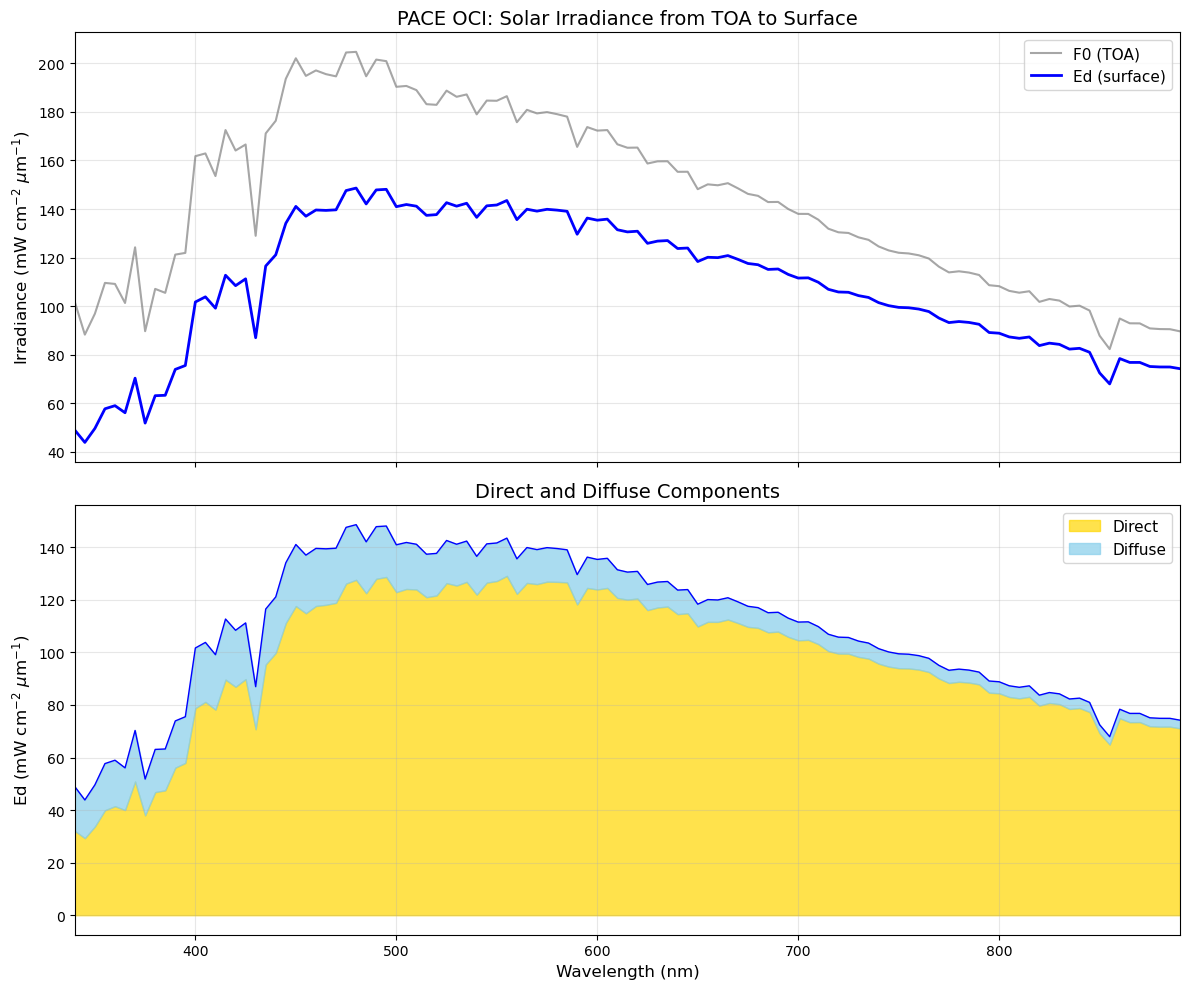

In [14]:
# Plot PACE hyperspectral Ed with components
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top panel: F0 and Ed
ax1.plot(result['wavelengths'], result['f0'], 'gray', linewidth=1.5, label='F0 (TOA)', alpha=0.7)
ax1.plot(result['wavelengths'], result['ed'], 'b-', linewidth=2, label='Ed (surface)')
ax1.set_ylabel('Irradiance (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
ax1.set_title('PACE OCI: Solar Irradiance from TOA to Surface', fontsize=14)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(340, 890)

# Bottom panel: Direct vs Diffuse
ax2.fill_between(result['wavelengths'], 0, result['ed_direct'], 
                 alpha=0.7, color='gold', label='Direct')
ax2.fill_between(result['wavelengths'], result['ed_direct'], result['ed'], 
                 alpha=0.7, color='skyblue', label='Diffuse')
ax2.plot(result['wavelengths'], result['ed'], 'b-', linewidth=1)
ax2.set_xlabel('Wavelength (nm)', fontsize=12)
ax2.set_ylabel('Ed (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
ax2.set_title('Direct and Diffuse Components', fontsize=14)
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### High-Resolution Spectral Details

The 1 nm resolution of the solar spectrum reveals fine spectral structure (Fraunhofer lines, etc.).

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_65207/2076090836.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Irradiance (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)


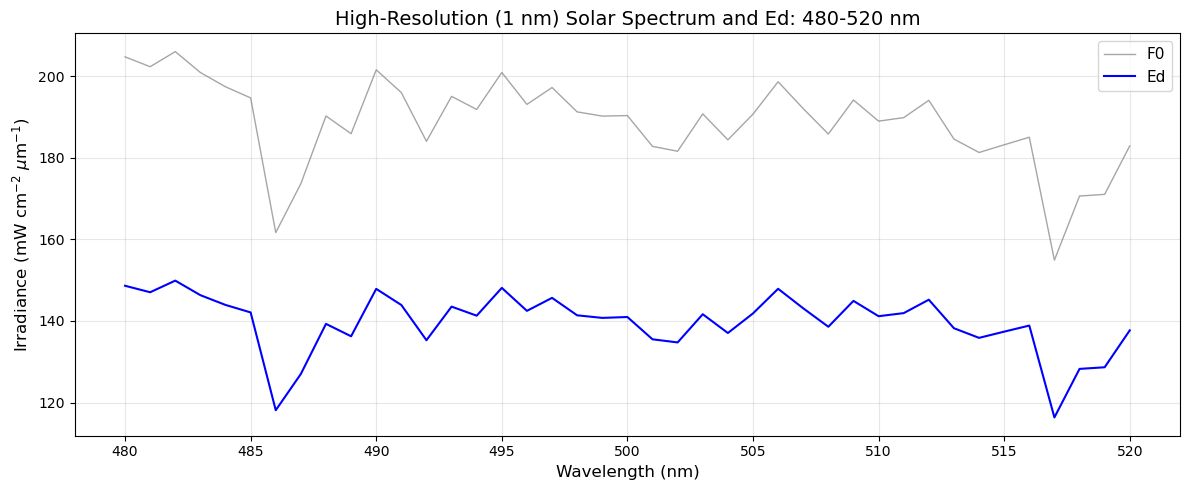

In [15]:
# Zoom in on a spectral region to see fine structure
result_hires = downwelling_irradiance_spectral(
    solar_zenith,
    wavelength_range=(480, 520),
    resolution=1.0,  # 1 nm resolution
)

plt.figure(figsize=(12, 5))
plt.plot(result_hires['wavelengths'], result_hires['f0'], 'gray', linewidth=1, 
         alpha=0.7, label='F0')
plt.plot(result_hires['wavelengths'], result_hires['ed'], 'b-', linewidth=1.5, label='Ed')

plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Irradiance (mW cm$^{-2}$ $\mu$m$^{-1}$)', fontsize=12)
plt.title('High-Resolution (1 nm) Solar Spectrum and Ed: 480-520 nm', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Using Ed for Remote Sensing Reflectance

The primary use of Ed is to convert water-leaving radiance (Lw) to remote-sensing reflectance (Rrs):

$$R_{rs} = \frac{L_w}{E_d(0^+)}$$

This normalization removes the effects of illumination conditions.

In [16]:
# Example: Calculate Rrs from simulated Lw
from correct_atmosphere.normalization import remote_sensing_reflectance

# Typical Lw values for Case 1 waters (low chlorophyll)
wavelengths = np.array([412, 443, 490, 555, 670])
lw_typical = np.array([0.8, 1.2, 1.5, 0.8, 0.1])  # W/m2/sr/nm

# Calculate Ed at these wavelengths
solar_zenith = 30.0
ed = downwelling_irradiance(wavelengths, solar_zenith)

# Convert Ed to same units as Lw (W/m2/nm)
ed_si = convert_irradiance_units(ed, "mW_cm2_um", "W_m2_nm")

# Calculate Rrs
rrs = remote_sensing_reflectance(lw_typical, ed_si)

print("Remote Sensing Reflectance Calculation:")
print("=" * 60)
print(f"{'Wavelength':<12} {'Lw':<15} {'Ed':<15} {'Rrs'}")
print(f"{'(nm)':<12} {'(W/m2/sr/nm)':<15} {'(W/m2/nm)':<15} {'(sr^-1)'}")
print("-" * 60)
for wl, lw, e, r in zip(wavelengths, lw_typical, ed_si, rrs):
    print(f"{wl:<12} {lw:<15.3f} {e:<15.2f} {r:.5f}")

Remote Sensing Reflectance Calculation:
Wavelength   Lw              Ed              Rrs
(nm)         (W/m2/sr/nm)    (W/m2/nm)       (sr^-1)
------------------------------------------------------------
412          0.800           12.85           0.06227
443          1.200           14.30           0.08389
490          1.500           15.89           0.09442
555          0.800           15.26           0.05242
670          0.100           12.53           0.00798


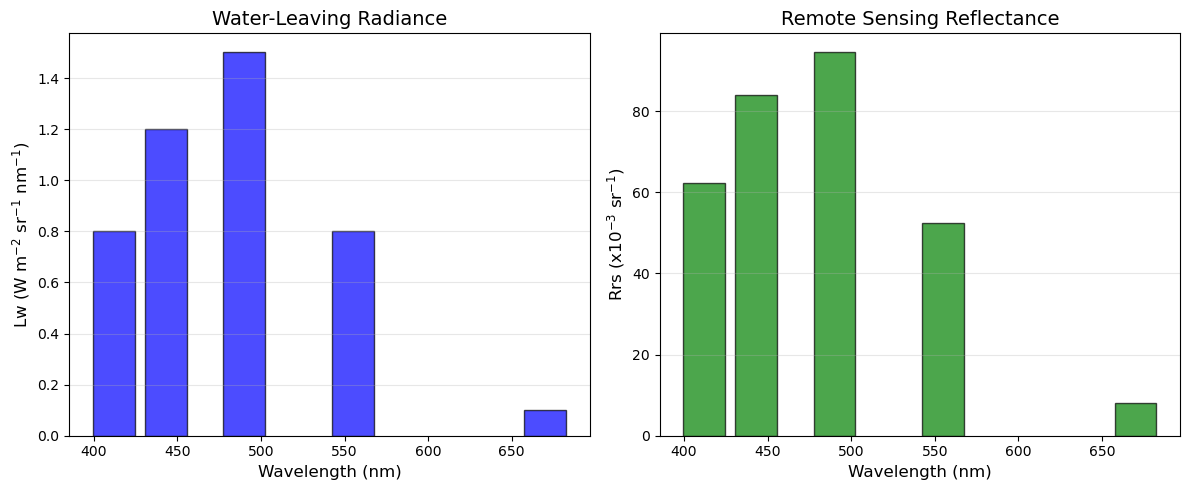

In [17]:
# Plot Lw and Rrs comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Lw spectrum
ax1.bar(wavelengths, lw_typical, width=25, color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Wavelength (nm)', fontsize=12)
ax1.set_ylabel('Lw (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)', fontsize=12)
ax1.set_title('Water-Leaving Radiance', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Rrs spectrum
ax2.bar(wavelengths, rrs * 1000, width=25, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Wavelength (nm)', fontsize=12)
ax2.set_ylabel('Rrs (x10$^{-3}$ sr$^{-1}$)', fontsize=12)
ax2.set_title('Remote Sensing Reflectance', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Sensitivity to Illumination Conditions

Unlike Lw, Rrs is relatively insensitive to changes in illumination (solar zenith, aerosols, etc.).

In [18]:
# Show that Rrs is stable under different conditions
# (using the same Lw scaled by Ed ratio)

conditions = [
    (30, 0.1, 'SZA=30, AOT=0.1'),
    (45, 0.1, 'SZA=45, AOT=0.1'),
    (30, 0.3, 'SZA=30, AOT=0.3'),
    (60, 0.2, 'SZA=60, AOT=0.2'),
]

wavelength = 443.0
rrs_target = 0.005  # sr^-1 (constant water property)

print("Demonstration: Rrs Stability Under Different Conditions")
print("=" * 65)
print(f"Target Rrs at {wavelength:.0f} nm: {rrs_target:.5f} sr^-1")
print("-" * 65)
print(f"{'Condition':<25} {'Ed':<15} {'Lw':<15} {'Rrs'}")
print(f"{'':<25} {'(W/m2/nm)':<15} {'(W/m2/sr/nm)':<15} {'(sr^-1)'}")
print("-" * 65)

for sza, aot, label in conditions:
    ed_val = downwelling_irradiance(wavelength, sza, aerosol_tau=aot)
    ed_si = convert_irradiance_units(ed_val, "mW_cm2_um", "W_m2_nm")
    lw_val = rrs_target * ed_si  # Lw adjusted to maintain constant Rrs
    rrs_calc = lw_val / ed_si
    print(f"{label:<25} {ed_si:<15.2f} {lw_val:<15.3f} {rrs_calc:.5f}")

Demonstration: Rrs Stability Under Different Conditions
Target Rrs at 443 nm: 0.00500 sr^-1
-----------------------------------------------------------------
Condition                 Ed              Lw              Rrs
                          (W/m2/nm)       (W/m2/sr/nm)    (sr^-1)
-----------------------------------------------------------------
SZA=30, AOT=0.1           13.40           0.067           0.00500
SZA=45, AOT=0.1           10.40           0.052           0.00500
SZA=30, AOT=0.3           11.68           0.058           0.00500
SZA=60, AOT=0.2           5.77            0.029           0.00500


---
## 5. Unit Conversions

Different communities use different units for irradiance. The module provides conversion utilities.

In [19]:
# Unit conversion examples
ed_mw = 180.0  # mW cm^-2 um^-1 (ocean color standard)

ed_w = convert_irradiance_units(ed_mw, "mW_cm2_um", "W_m2_nm")
ed_uw = convert_irradiance_units(ed_mw, "mW_cm2_um", "uW_cm2_nm")

print("Irradiance Unit Conversions:")
print("=" * 50)
print(f"Original: {ed_mw} mW cm^-2 um^-1")
print(f"         = {ed_w} W m^-2 nm^-1")
print(f"         = {ed_uw} uW cm^-2 nm^-1")
print("\nNote: 1 mW cm^-2 um^-1 = 0.1 W m^-2 nm^-1")

Irradiance Unit Conversions:
Original: 180.0 mW cm^-2 um^-1
         = 18.0 W m^-2 nm^-1
         = 1800.0 uW cm^-2 nm^-1

Note: 1 mW cm^-2 um^-1 = 0.1 W m^-2 nm^-1


---
## Summary

This notebook demonstrated the key capabilities of the `downwelling` module:

1. **High-resolution solar spectrum** - TSIS-1 HSRS at 1 nm resolution
2. **Earth-Sun distance correction** - ~6.7% annual variation
3. **Ed components** - Direct and diffuse contributions
4. **Atmospheric effects** - Solar zenith angle and aerosol loading
5. **PACE hyperspectral support** - 340-890 nm at 5 nm resolution
6. **Rrs calculation** - Converting Lw to Rrs using Ed

### Key Equations

$$E_d(0^+) = F_0 \cos\theta_s \cdot T_{atm}$$

$$R_{rs} = \frac{L_w}{E_d(0^+)}$$

### References

- Coddington, O., et al. (2021). The TSIS-1 Hybrid Solar Reference Spectrum. GRL.
- Mobley et al. (2016). NASA/TM-2016-217551.